#### Dating App Algorithm A/B Test Analysis

This script analyzes the results of an A/B test for a new matching algorithm in an online dating application.
The goal is to determine whether the new algorithm has improved the quality of the service.

Dataset Description:

- Users in group 0 used the application with the old algorithm. All users in group 1 used the application with the new algorithm for profile search.

- If users mutually like each other, it is called a match, and the users have the opportunity to connect.

is_match can have a value of 0 OR 1:
- if there is a match, it equals 1,
- if there is no match, it equals 0.

Key Steps:
1. EDA
2. Identify key metrics for service quality.
3. Perform statistical analyses to compare metrics between the two groups.

Metrics for Evaluation:
- Match-to-no-match ratio.
- User activity (number of likes given).
- Number of matches per user.

Findings:
- The match rates in the control and test groups are not equal.
- The average activity in the test and control groups differs.
- The average number of matches in the test and control groups differs.

Author: Elina Krasnobaeva

Contact: 
- elina8kr@gmail.com

- https://www.linkedin.com/in/elina-krs/




In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency, chi2 
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt

### EDA

In [2]:
# Base URL for accessing Yandex Disk
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# File URLs on Yandex Disk
url_data = 'https://disk.yandex.ru/d/txn7q-CE2zSaPg'

# Creating final URLs for downloading each file by combining the base URL and query parameters
# using the urlencode() function from the urllib.parse module
final_url = base_url + urlencode(dict(public_key= url_data))

# Making requests to the Yandex Disk API to download the files using the generated final URLs
# The requests.get() function returns a response in JSON format, from which the download URL ('href') is extracted
df = pd.read_csv(requests.get(final_url).json()['href'])


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [5]:
df.shape

(14514, 4)

In [6]:
df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [7]:
df.describe(include='all')

,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


In [8]:
df.duplicated().sum()

0

In [9]:
# Output the sizes of the control and test groups
df.groupby('group', as_index = False).agg({'is_match': 'count'})

,group,is_match
0,0,4792
1,1,9722


In [10]:
# Output unique users user_id_1 in groups 0 and 1
df.groupby('group').user_id_1.nunique()

group
0    501
1    499
Name: user_id_1, dtype: int64

In [11]:
# Output unique users user_id_2 in groups 0 and 1
df.groupby('group').user_id_2.nunique()

group
0    501
1    499
Name: user_id_2, dtype: int64

The number of users in both groups is the same, but the number of surveys per individual has increased. This will need to be verified using A/B tests.

In [12]:
df.groupby(['user_id_2', 'is_match'], as_index = False)\
    .agg({'user_id_1':'count'})\
    .rename(columns = {'user_id_1':'count_user1'})

,user_id_2,is_match,count_user1
0,1,0,8
1,1,1,5
2,2,0,14
3,2,1,9
4,3,0,6
...,...,...,...
1915,998,1,8
1916,999,0,12
1917,999,1,1
1918,1000,0,8


In [13]:
df.groupby(['user_id_1', 'is_match'], as_index = False)\
    .agg({'user_id_2':'count'})\
    .rename(columns = {'user_id_2':'count_user2'}).head()  

,user_id_1,is_match,count_user2
0,1,0,13
1,1,1,11
2,2,0,9
3,2,1,7
4,3,0,11


In [14]:
df.query('user_id_1 == 1')

,user_id_1,user_id_2,group,is_match
1368,1,585,1,0
1841,1,213,1,1
2199,1,253,1,0
2218,1,560,1,0
3214,1,187,1,0
3760,1,284,1,0
5501,1,644,1,1
7087,1,687,1,0
7322,1,84,1,0
8268,1,812,1,0


In [15]:
df.query('user_id_1 == 213')

,user_id_1,user_id_2,group,is_match
713,213,510,1,1
3749,213,641,1,0
4535,213,330,1,1
6391,213,148,1,0
7464,213,740,1,1
8009,213,163,1,0
8831,213,391,1,0
9063,213,368,1,1
9114,213,828,1,0
10162,213,549,1,0


I see that the same user can appear as both user_id_1 and user_id_2. I can assume that user_id_1 is the identifier of the user who liked user_id_2 first.

Is there any overlap between the user groups? We can use sets to check this.

In [16]:
gr_01 = set(df.query("group==0").user_id_1)
gr_11 = set(df.query("group==1").user_id_1)

gr_01.intersection(gr_11)

set()

In [17]:
gr_02 = set(df.query("group==0").user_id_2)
gr_12 = set(df.query("group==1").user_id_2)

gr_02.intersection(gr_12)

set()

I see that users from the control group do not overlap with users from the test group, so I can proceed with the A/B test.

In [18]:
# Output the results for the control and test groups.
grouped_data =  df.groupby(['group', 'is_match'], as_index = False)\
    .agg({'user_id_1':'count'})\
    .rename(columns={'user_id_1': 'count'})
grouped_data

,group,is_match,count
0,0,0,3858
1,0,1,934
2,1,0,5813
3,1,1,3909


### Metrics

To evaluate which algorithm for matching profiles is better, I decided to check several metrics:
- Match-to-non-match ratio,
- User activity (number of likes given),
- Number of matches per user.

### Testing

### Hypothesis №1: The ratio of matches to non-matches has changed.

Let's look at the cross-tabulation:

In [19]:
data = df.groupby(['group', 'is_match'], as_index=False)\
    .agg({'user_id_1':'count'})\
    .pivot(index='is_match', columns='group', values='user_id_1')\
    .reset_index()\
    .rename(columns ={0:'control', 1: 'test'})
data.head()

group,is_match,control,test
0,0,3858,5813
1,1,934,3909


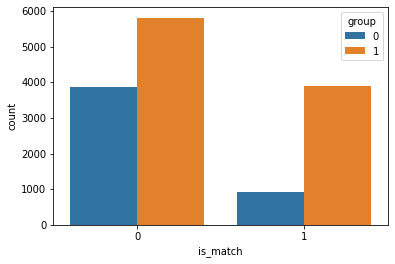

In [20]:
sns.barplot(x='is_match', y='count', hue='group', data = grouped_data)
plt.show()

Visual inspection suggests there are more matches in the test group compared to the control group. It's necessary to check for statistical differences.

To do this, I will use the chi-square test because categorical variables are involved, and we need to compare proportions between groups.

The hypotheses can be stated as follows:

- **Null Hypothesis (𝐻0)**: The proportions in the control and test groups are equal.
- **Alternative Hypothesis (𝐻1)**: The proportions in the control and test groups are not equal.

In [21]:
pd.crosstab(df.is_match, df.group)

group,0,1
is_match,,
0,3858,5813
1,934,3909


In [22]:
exp, obs, stats = pg.chi2_independence(data=df, 
                                       x="group", 
                                       y="is_match")

In [23]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


The p-value is 1.441829916366341e-136, indicating statistical significance.

The null hypothesis is rejected.

Therefore, the proportions in the control and test groups are NOT equal.

### Hypothesis №2: User activity has changed

In our case, user activity refers to how many likes a user has given to other users.

In [24]:
# Calculate all the likes from the control group that user_1 gave (regardless of whether user_2 reacted or not).
control_user_1 = df.query('group == 0')\
    .groupby(['user_id_1', 'group'], as_index = False)\
    .agg({'user_id_2':'count'})

control_user_1.columns = ['user_id', 'group', 'likes']
control_user_1.head()

,user_id,group,likes
0,4,0,9
1,10,0,6
2,12,0,12
3,14,0,8
4,15,0,20


In [25]:
# Calculate all likes that user_2 gave to user_1 (assuming that if there was a match, user_2 liked back)
control_user_2 = df.query('group == 0 and is_match == 1')\
    .groupby(['user_id_1', 'group'], as_index = False)\
    .agg({'user_id_2':'count'})
control_user_2.columns = ['user_id', 'group', 'likes']
control_user_2.head()

,user_id,group,likes
0,4,0,2
1,10,0,3
2,12,0,1
3,15,0,3
4,17,0,1


In [26]:
control_activities = pd.merge(control_user_2, control_user_1, on='user_id', how='outer').fillna(0)

In [27]:
# Sum of total likes
control_activities['total_activities'] = control_activities.likes_x + control_activities.likes_y

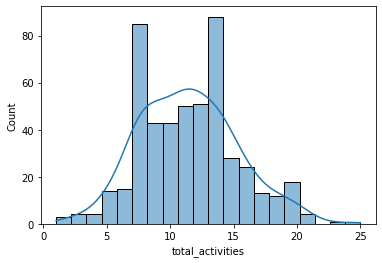

In [28]:
# Distribution of user activities for the control group
sns.histplot(control_activities.total_activities, kde =True)

Let's do the same for the test group.

In [29]:
test_user_1 = df.query('group == 1')\
    .groupby(['user_id_1','group'], as_index = False)\
    .agg({'user_id_2':'count'})
test_user_1.columns = ['user_id', 'group', 'likes']

In [30]:
test_user_2 = df.query('group == 1 and is_match == 1')\
    .groupby(['user_id_1', 'group'], as_index = False)\
    .agg({'user_id_2':'count'})
test_user_2.columns = ['user_id', 'group', 'likes']

In [31]:
test_activities = pd.merge(test_user_2, test_user_1, on='user_id', how='outer').fillna(0)

In [32]:
test_activities['total_activities'] = test_activities.likes_x + test_activities.likes_y

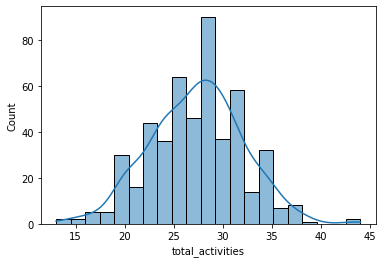

In [33]:
# Distribution of user activities for the test group
sns.histplot(test_activities.total_activities, kde =True)

Calculate the average activity for the test and control groups.

In [34]:
control_activities.total_activities.mean()

11.429141716566866

In [35]:
test_activities.total_activities.mean()

27.316633266533067

The average activity of the test group is higher than that of the control group; it is necessary to check if there are statistical differences.

### Testing

check if the variance within each group is equal

> Null hypothesis: The variances are equal in both groups.

> Alternative hypothesis: The variances differ between the groups.

In [36]:
ss.levene(control_activities.total_activities, test_activities.total_activities)

LeveneResult(statistic=14.758698548934039, pvalue=0.0001298951892000579)

The p-value is 0.0001298951892000579 
indicating that the variances are different between the two groups.

To conduct the test, I will use Welch's t-test because the variances differ between the groups.

In [37]:
ttest_ind(test_activities.total_activities,control_activities.total_activities, equal_var=False)

Ttest_indResult(statistic=58.17375083372977, pvalue=4.5161394e-317)

p-value=4.5161394e-317 indicates a statistically significant result.

Therefore, the average user activity per user significantly differs in the test group.

### Hypothesis №3: The number of matches per user has changed

In [38]:
matches_per_user = df.query("is_match==1").groupby(["group", "user_id_1"], as_index=False).size()
matches_per_user

,group,user_id_1,size
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1
...,...,...,...
915,1,987,8
916,1,992,8
917,1,993,6
918,1,998,10


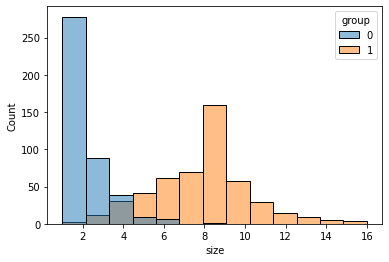

In [39]:
sns.histplot(data=matches_per_user, x="size", hue="group")

### Testing

check if the variance within each group is equal

> Null hypothesis: The variances are equal in both groups.

> Alternative hypothesis: The variances differ between the groups.

In [ ]:
ss.levene(matches_per_user.query("group==0")["size"], matches_per_user.query("group==1")["size"])

The p-value is 5.4853674460949236e-36)
indicating that the variances are different between the two groups.

To conduct the test, I will use Welch's t-test because the variances differ between the groups.

In [ ]:
ttest_ind(matches_per_user.query("group==0")["size"], 
         matches_per_user.query("group==1")["size"], equal_var=False)

In [ ]:
p-value=9.229584625571108e-216 indicates a statistically significant result.

Therefore, the average number of matches significantly differs in the test group.

#### Conclusion
Statistically, we have confirmed the hypothesis that:
- the proportions in the control and test groups are not equal,
- the average activity differs between the test and control groups,
- the average number in the test group differs from that in the control group.

#### Update to be deployed.